# This file tunes the final Random Forest Model

In [59]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn_evaluation import plot
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

w = pd.read_csv("../Data/vectorizedWords.csv").to_numpy()
df = pd.read_csv("../Data/2.5k_reviews.csv")

## 1.) Put Vectorized features into df as it was saved separately

In [60]:
df["vectorization"] = [i for i in w]

## 2.) Undersample as data is unbalanced, ratio is approximately 10:8 for negative:positive

In [66]:
num0s = df.sentiment.value_counts()[0] # Get number of 0s (negative reviews)
subset_index = df[df.sentiment == 1].sample(int(df.shape[0] - num0s*1.8)).index # Obtain positive reviews indexes to be dropped
subset = df.drop(subset_index).reset_index(drop=True) # Drop extra positive reviews for undersampling
print("Number of negative reviews: "+str(len(subset)-subset.sentiment.sum())+"; Number of positive reviews: "+str(subset.sentiment.sum()))

Number of negative reviews: 701; Number of positive reviews: 561


##### I took a random sample from the subset to split the data into a trianing set and validation set

In [67]:
subset = subset.sample(1000)
subset.sentiment.value_counts()

sentiment
0    561
1    439
Name: count, dtype: int64

In [68]:
rest = df[~df.index.isin(subset.index)]

In [69]:
y = subset.sentiment.values
X = subset.vectorization.values

## 3.) Test Train and run the best Random Forest Classifier Model
##### I used test train split to split the training set into a training and test set to see model performance. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=43)
X_train = np.stack(X_train, axis=0) # Expand the array for model
X_test = np.stack(X_test, axis=0) # Expand the array for model

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       452
           1       0.99      0.96      0.98       348

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800


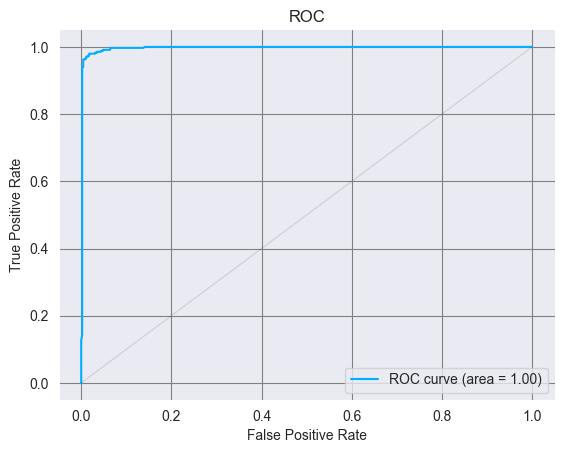

In [71]:
# Initialize RF model with 500 trees, a max depth of 10 (not too much as it will overfit) and max_feature of 2. Other parameters were tested to find the best ones.
pipeline_rf = RandomForestClassifier(n_estimators=500,max_depth=9,max_features=3,criterion='entropy',n_jobs=-1)
pipeline_rf = pipeline_rf.fit(X_train, y_train)

# Training Set
y_pred_train_rf = pipeline_rf.predict(X_train)
# Reported average results will be shown in 05_testPKL.ipynb
print(classification_report(y_train,y_pred_train_rf))
y_score = pipeline_rf.predict_proba(X_train) # Predict estimates for all classes
roc = plot.ROC.from_raw_data(y_train, y_score) # Using sklearn ROC plot function

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       109
           1       0.73      0.65      0.69        91

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.73      0.73       200


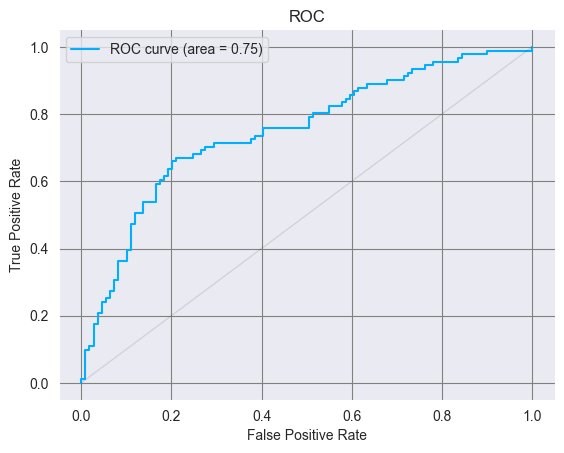

In [72]:
# Test Set
y_pred_test_rf = pipeline_rf.predict(X_test)
print(classification_report(y_test,y_pred_test_rf))
y_score = pipeline_rf.predict_proba(X_test) # Predict estimates for all classes
roc = plot.ROC.from_raw_data(y_test, y_score) # Using sklearn ROC plot function
#plt.savefig('../Results/04_ROC.png'); # Save fig

In [76]:
joblib.dump(pipeline_rf,'../Data/best_model.pkl') # Save model as pkl file

['../Data/best_model.pkl']

## 4.) Test model on 100 N sample from Validation Set 

In [73]:
test_case = rest.sample(100, random_state=1)
y_mod = test_case.sentiment.values
X_mod = test_case.vectorization.values
X_mod = np.stack(X_mod, axis=0) # Expand the array for model
y_pred_mod = pipeline_rf.predict(X_mod)
print(classification_report(y_mod,y_pred_mod))

              precision    recall  f1-score   support

           0       0.52      0.86      0.65        35
           1       0.88      0.57      0.69        65

    accuracy                           0.67       100
   macro avg       0.70      0.71      0.67       100
weighted avg       0.75      0.67      0.68       100


## 5.) Visualize results for 100N test using ROC curve

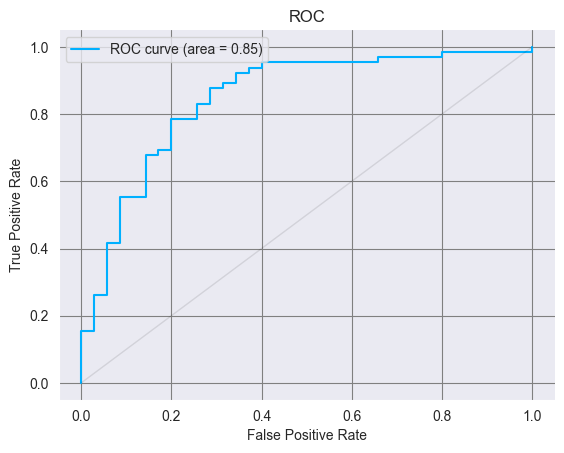

In [77]:
y_score = pipeline_rf.predict_proba(X_mod) # Predict estimates for all classes
roc = plot.ROC.from_raw_data(y_mod, y_score) # Using sklearn ROC plot function
plt.savefig('../Results/04_ROC.png'); # Save fig